# In this notebook we fit an ensemble of SEIR models with hidden states to the Moscow Covid-19 data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import joblib

In [3]:
sns.set()
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
from sir_models.models import SEIRHidden
from sir_models.ensemble import EnsembleModel
from sir_models.fitters import HiddenCurveFitter
from sir_models.utils import stepwise, eval_on_select_dates_and_k_days_ahead

# Load data

In [7]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])
df = df.dropna()

In [8]:
df.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
6,2020-03-18,86,1,0,0,31,0,85,44.43,0.57,0.0,0.0,12.29,0.14,43.86
7,2020-03-19,98,1,0,0,12,0,97,55.43,0.71,0.0,0.0,11.00,0.14,54.71
8,2020-03-20,131,5,0,0,33,4,126,70.43,1.43,0.0,0.0,15.00,0.71,69.00
9,2020-03-21,137,8,0,0,6,3,129,85.00,2.57,0.0,0.0,14.57,1.14,82.43
10,2020-03-22,191,8,0,0,54,0,183,107.29,3.57,0.0,0.0,22.29,1.00,103.71


# Model

In [9]:
train_subset = df[
    #(df.date >= '2020-03-25') &
    (df.date <= '2020-11-30')]

In [10]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

264   2020-12-01
265   2020-12-02
266   2020-12-03
Name: date, dtype: datetime64[ns]

In [11]:
class SEIRHiddenMoscow(SEIRHidden):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)
        params['epidemic_started_days_ago'].value = 20
        return params
    
class HiddenCurveFitterMoscow(HiddenCurveFitter):
    def __init__(self, *args,
                 new_recoveries_col='recovered_per_day',
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.new_recoveries_col = new_recoveries_col
        
    def residual(self, params, t_vals, data, model):
        model.params = params

        initial_conditions = model.get_initial_conditions(data)

        (S, E, I, Iv, R, Rv, D, Dv), history = model.predict(t_vals, initial_conditions, history=True)
        (new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)
        true_daily_cases = data[self.new_cases_col][:len(new_infected_visible)].values
        true_daily_deaths = data[self.new_deaths_col][:len(new_dead_visible)].values
        true_daily_recoveries = data[self.new_recoveries_col][:len(new_recovered_visible)].values

        resid_I_new = self.resid_transform(true_daily_cases, new_infected_visible)
        resid_D_new = self.resid_transform(true_daily_deaths, new_dead_visible)
        resid_R_new = self.resid_transform(true_daily_recoveries, new_recovered_visible)

        residuals = np.concatenate([
            resid_I_new,
            resid_D_new,
            resid_R_new,
        ]).flatten()
        return residuals


In [12]:
stepwize_size = 60
model = SEIRHiddenMoscow(stepwise_size=stepwize_size)
fitter = HiddenCurveFitterMoscow(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
     max_iters=2000,
     save_params_every=10,
#      brute_params=['epidemic_started_days_ago']
)
ensemble = EnsembleModel.train(model, fitter, train_subset)

KeyboardInterrupt: 

In [ ]:
joblib.dump(ensemble, 'ensemble_russia.pkl')

In [ ]:
result = ensemble.fitter.result
result

In [ ]:
incubation_days = model.params['incubation_days'].value
infectious_days = model.params['infectious_days'].value
print(f'Incubation period: {incubation_days:.2f}')
print(f'Infectious period: {infectious_days:.2f}')

In [ ]:
aggregate_states, aggregate_daily, model_states, model_daily_vals, history = ensemble.predict(train_subset)

In [ ]:
(S, E, I, Iv, R, Rv, D, Dv) = aggregate_states
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = aggregate_daily 

In [ ]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')

plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')

plt.plot(train_subset.date, train_subset['deaths_per_day_ma7'], label='ground truth')
plt.legend()
plt.title('Daily deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_infected'], label='ground truth')
plt.plot(train_subset.date, I.cumsum(), label='predicted invisible', color='red', linestyle='dashed' )
plt.plot(train_subset.date, Iv.cumsum(), label='predicted visible', color='red')
plt.legend()
plt.title('Total infections')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'], label='ground truth')

plt.plot(train_subset.date[:-1], new_infected_visible, label='daily infected_visible', color='red')

plt.plot(train_subset.date[:-1], new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

# Obtain forecast

In [ ]:
test_t = len(train_subset) + np.arange(len(test_subset))
train_t = np.arange(len(train_subset))

In [ ]:
train_t, test_t

In [ ]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [ ]:
(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv), history = model.predict(test_t, test_initial_conds)

In [ ]:
(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible) = model.compute_daily_values(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
# plt.plot(train_subset.date, D, label='train fit invisible')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='black')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['deaths_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['deaths_per_day'], label='test ground truth', color='black')
plt.plot(test_subset.date[:-1], test_new_dead_invisible, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_dead_visible, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Daily deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['recovered_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['recovered_per_day'], label='test ground truth', color='green')
plt.plot(test_subset.date[:-1], test_new_recovered_invisible, label='test forecasted invisible', color='green', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_recovered_visible, label='test forecasted visible', color='green', linestyle=':')
plt.legend()
plt.title('Daily recoveries')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='train ground truth')
plt.plot(test_subset.date, test_subset['total_recovered'], label='test ground truth', color='green')
plt.plot(test_subset.date, test_R, label='test forecasted invisible', color='green', linestyle='dashed')
plt.plot(test_subset.date, test_Rv, label='test forecasted visible', color='green', linestyle=':')
plt.legend()
plt.title('Total recovered')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_infected'], label='train ground truth')
# plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, test_subset['total_infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, Iv.sum()+test_Iv.cumsum(), label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total Infected')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['infected_per_day'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_infected_invisible, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_infected_visible, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Daily infections')
plt.show()

# Eval 30 days ahead on fixed dates

In [13]:
K = 30

In [14]:
# Regions where Rt does not jump much
eval_dates = pd.date_range(start='2020-06-01', end='2020-09-01')[::3]
eval_dates[:10], len(eval_dates)

(DatetimeIndex(['2020-06-01', '2020-06-04', '2020-06-07', '2020-06-10',
                '2020-06-13', '2020-06-16', '2020-06-19', '2020-06-22',
                '2020-06-25', '2020-06-28'],
               dtype='datetime64[ns]', freq='3D'),
 31)

In [17]:
def eval_ensemble_moscow(train_df, t, train_t, eval_t):
    model = SEIRHiddenMoscow()
    fitter = HiddenCurveFitterMoscow(
        new_deaths_col='deaths_per_day_ma7',
        new_cases_col='infected_per_day_ma7',
        new_recoveries_col='recovered_per_day_ma7',
        max_iters=1000,
        save_params_every=10,
        
    )
    ensemble = EnsembleModel.train(model, fitter, train_df)

    aggregate_states, _, _, _, _ = ensemble.predict(train_df, 
                                                                                                  t=train_t,
                                                                                                  history=False)

    test_initial_conds = [compartment[-1] for compartment in aggregate_states]

    test_states, aggregate_daily, model_states, model_daily_vals, history = ensemble.predict(t=eval_t, 
                                                                                             initial_conditions=test_initial_conds, 
                                                                                             history=False)
    return ensemble, fitter, test_states

In [18]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                                     eval_func=eval_ensemble_moscow, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

In [19]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]

In [20]:
model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.total_dead.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].total_dead]*K for tdf in train_dfs]

In [21]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [22]:
print('Mean overall error baseline', np.mean(overall_errors_baseline).round(3))
print('Mean overall error model', np.mean(overall_errors_model).round(3))

print('Mean point error baseline', np.mean(point_errors_baseline).round(3))
print('Mean point error model', np.mean(point_errors_model).round(3))

Mean overall error baseline 326.699
Mean overall error model 3029.303
Mean point error baseline 579.323
Mean point error model 4025.918


### Take a look on one prediction

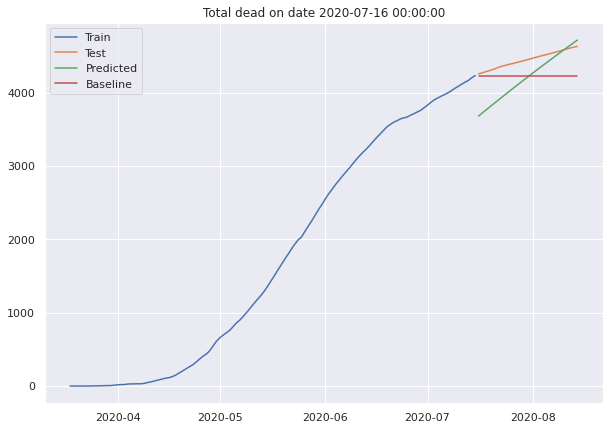

In [23]:
train_df = train_dfs[15]
test_df = test_dfs[15]
model_preds = model_predictions[15]
baseline_predictions = baseline_pred_D[15]
fitter = fitters[15]
plt.figure(figsize=(10, 7))
plt.plot(train_df.date, train_df.total_dead, label='Train')
plt.plot(test_df.date, test_df.total_dead, label='Test')
plt.plot(test_df.date, model_preds[7], label='Predicted')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
plt.legend()
plt.title(f'Total dead on date {test_df.date.iloc[0]}')
plt.show()

In [24]:
fitter.result

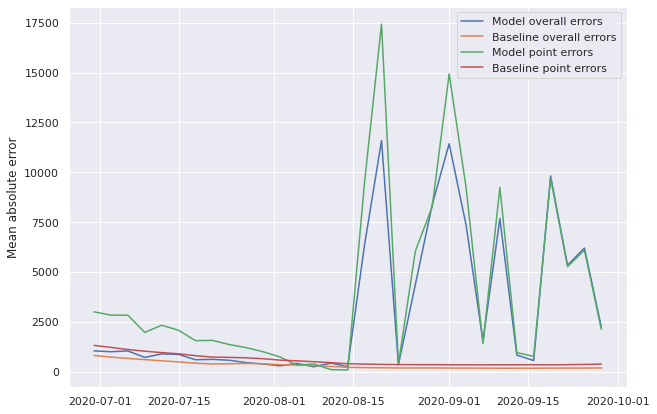

In [25]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model overall errors')
plt.plot(x_dates, overall_errors_baseline, label='Baseline overall errors')

plt.plot(x_dates, point_errors_model, label='Model point errors')
plt.plot(x_dates, point_errors_baseline, label='Baseline point errors')

plt.legend()
plt.ylabel('Mean absolute error')
plt.show()

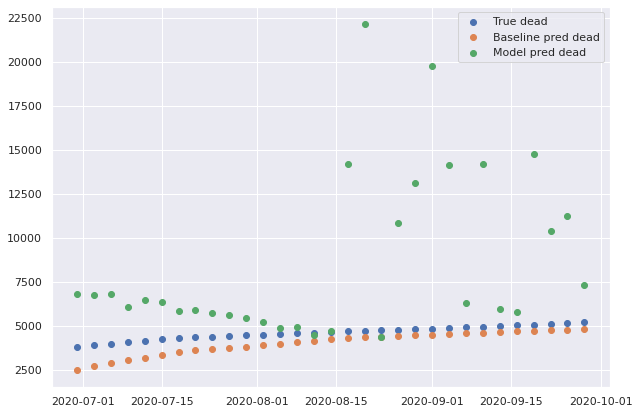

In [26]:
plt.figure(figsize=(10, 7))
plt.scatter(x_dates, [v[-1] for v in true_D], label='True dead')
plt.scatter(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead')
plt.scatter(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead')

plt.legend()
plt.show()